In [ ]:
import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates



In [ ]:
!pip install earthengine-api

In [ ]:
# Authenticate to Earth Engine.
ee.Authenticate()

 # Get your Google Cloud Project ID.
!gcloud config get-value project

  # Set the project ID.
  # Replace 'your-project-id' with the actual project ID
ee.Initialize(project='ee6-glowwithkoni')

(unset)


Define Region of Interest (Mehsana, Gujarat)

In [ ]:

roi = ee.Geometry.Rectangle([72.5, 23.5, 72.8, 23.8])

In [ ]:
!pip install folium
import folium
# Define a function to add Earth Engine layers to a Folium map
def add_ee_layer(self, ee_object, vis_params, name):
    if isinstance(ee_object, ee.Image):
        ee_object = ee_object.visualize(**vis_params)
    elif isinstance(ee_object, ee.Geometry) or isinstance(ee_object, ee.FeatureCollection):
        # Paint the geometry onto an image for visualization
        ee_object = ee.Image().paint(ee_object, 1, 2).visualize(**vis_params)
    else:
        raise Exception("Unsupported Earth Engine object type")

    # Convert the Earth Engine object to URL format for Folium
    map_id = ee.Image(ee_object).getMapId()
    folium.raster_layers.TileLayer(
        tiles=map_id["tile_fetcher"].url_format,
        attr="Google Earth Engine",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)

# Add the custom layer method to the Folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Create a Folium map centered over the study area
map_center = [23.65, 72.65]  # Center latitude and longitude
m = folium.Map(location=map_center, zoom_start=12, tiles=None)  # No default basemap

# Add Google Satellite basemap
folium.TileLayer(
    tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    attr="Google Satellite",
    name="Google Satellite",
).add_to(m)

# Visualization parameters for the study area
vis_params = {"palette": ["red"], "opacity": 0.8}

# Add the ROI to the map
m.add_ee_layer(roi, vis_params, "Study Area")

# Add layer control to toggle visibility
folium.LayerControl().add_to(m)

# Display the map
m

In [ ]:
#Step 2: Load Sentinel-1 SAR data (VV polarization) for 2023
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
               .filterBounds(roi) \
               .filterDate('2019-01-01', '2023-12-31') \
               .filter(ee.Filter.eq('instrumentMode', 'IW')) \
               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
               .select('VV')

# Step 3: Average VV backscatter to reduce noise
sentinel1_avg = sentinel1.mean()

# Step 4: Clip the averaged image to the ROI
sentinel1_roi = sentinel1_avg.clip(roi)

# Step 5: Define visualization parameters for backscatter
vis_params = {
    'min': -25,  # VV backscatter values range typically between -30 to 0 dB
    'max': 0,
    'palette': ['blue', 'green', 'yellow', 'red']  # Blue for low backscatter, Red for high
}

# Step 6: Create a Map Object using geemap
map_obj = geemap.Map()

# Step 7: Add Sentinel-1 VV Backscatter layer to the map
map_obj.addLayer(sentinel1_roi, vis_params, 'Sentinel-1 VV Backscatter')

# Step 8: Center the map on the ROI and set zoom level
map_obj.centerObject(roi, 10)

# Display the Map
map_obj

Map(center=[23.650014824417187, 72.65000000000028], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Function to export monthly images for a range of years
def export_monthly_images(start_year, end_year):
    for year in range(start_year, end_year + 1):  # Loop through each year in the range
        for month in range(1, 13):  # Loop through each month
            # Define the date range for each month
            start_date = ee.Date(f'{year}-{month:02d}-01')
            end_date = start_date.advance(1, 'month')

            # Load Sentinel-1 data for the specified month
            monthly_image = (ee.ImageCollection('COPERNICUS/S1_GRD')
                             .filterBounds(roi)
                             .filterDate(start_date, end_date)
                             .filter(ee.Filter.eq('instrumentMode', 'IW'))
                             .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
                             .select('VV')  # Select only the VV band

                             .mean()  # Calculate the mean for the month
            )

            # Print image properties for verification
            print(f"Exporting image for {start_date.get('year').getInfo()}-{start_date.get('month').getInfo()}")

            # Export the monthly image
            geemap.ee_export_image(
                monthly_image,
                filename=f"sentinel1_soil_moisture_{year}_{month:02d}.tif",
                scale=100,  # Adjust the scale as needed
                region=roi,
                file_per_band=False
            )

# Call the function to export monthly images for 2019 to 2023
export_monthly_images(2019, 2023)


Exporting image for 2019-1
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_01.tif
Exporting image for 2019-2
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_02.tif
Exporting image for 2019-3
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_03.tif
Exporting image for 2019-4
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_04.tif
Exporting image for 2019-5
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_05.tif
Exporting image for 2019-6
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_06.tif
Exporting image for 2019-7
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019_07.tif
Exporting image for 2019-8
Generating URL ...
Please wait ...
Data downloaded to /content/sentinel1_soil_moisture_2019

Load Sentinel-1 SAR Data (2023) and Calculate Backscatter Time Series

In [ ]:
# Function to get the time series of VV backscatter at a point or area
def get_backscatter_time_series(image_collection, aoi, scale=10000):
    def extract_backscatter(image):
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi,
            scale=scale
        ).get('VV')

        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'backscatter': value
        })

    return image_collection.map(extract_backscatter).getInfo()


# Get time series data from Sentinel-1 (this part is assumed)
time_series_data = get_backscatter_time_series(sentinel1.filterDate('2019-01-01', '2023-12-31'), roi)

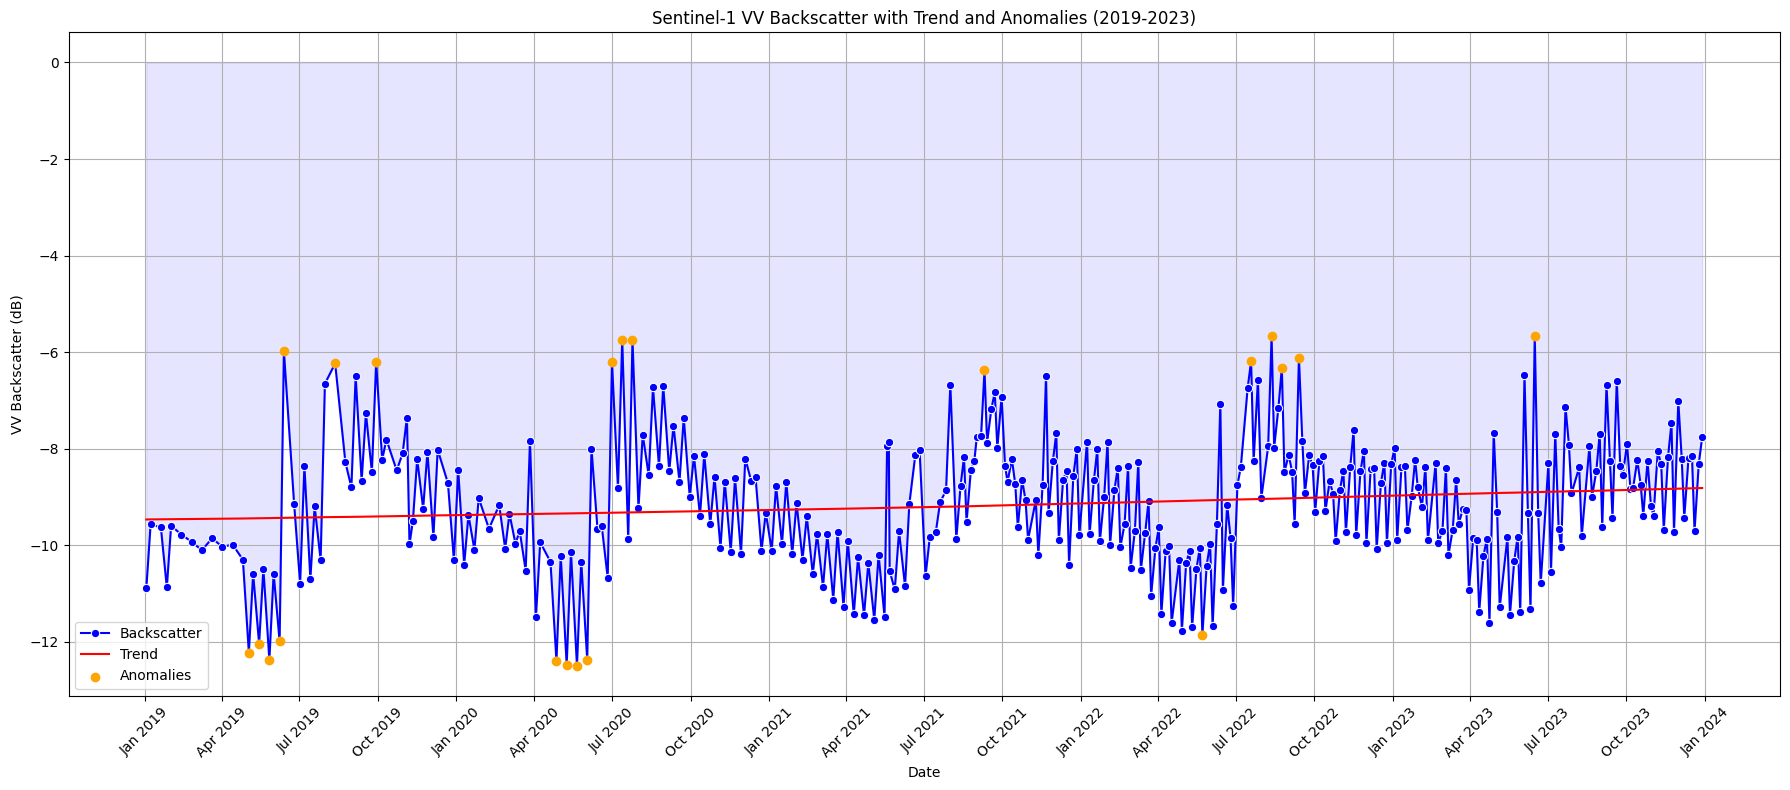

Statistical Analysis:
Average VV Backscatter: -9.14 dB
Standard Deviation of VV Backscatter: 1.36 dB
Average Daily Change: 0.009 dB
Maximum Increase in Backscatter: 6.02 dB
Maximum Decrease in Backscatter: -4.12 dB
Number of Anomalies Detected: 21


In [ ]:
# Create a DataFrame
df = pd.DataFrame(time_series_data['features'])
df['date'] = pd.to_datetime(df['properties'].apply(lambda x: x['date']))
df['backscatter'] = df['properties'].apply(lambda x: x['backscatter'])
df = df[['date', 'backscatter']].dropna().sort_values(by='date').reset_index(drop=True)

# Basic statistics
mean_backscatter = df['backscatter'].mean()
std_backscatter = df['backscatter'].std()

# Trend calculation using linear regression
slope, intercept, r_value, p_value, std_err = linregress(df.index, df['backscatter'])
df['trend'] = intercept + slope * df.index

# Temporal variability (day-to-day change in backscatter)
df['backscatter_change'] = df['backscatter'].diff()
mean_change = df['backscatter_change'].mean()
std_change = df['backscatter_change'].std()

# Anomaly detection (values that deviate beyond 2 standard deviations from the mean)
threshold = 2 * std_backscatter
df['anomaly'] = np.abs(df['backscatter'] - mean_backscatter) > threshold
anomalies = df[df['anomaly']]

# Plotting the Backscatter, Trend, and Anomalies
plt.figure(figsize=(18, 8))
sns.lineplot(data=df, x='date', y='backscatter', marker='o', label='Backscatter', color='blue')
sns.lineplot(data=df, x='date', y='trend', color='red', label='Trend')

# Plotting anomalies
plt.scatter(anomalies['date'], anomalies['backscatter'], color='orange', label='Anomalies', zorder=5)

# Set x-axis major locator and formatter for every 6 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.fill_between(df['date'], df['backscatter'], color='blue', alpha=0.1)
plt.title('Sentinel-1 VV Backscatter with Trend and Anomalies (2019-2023)')
plt.xlabel('Date')
plt.ylabel('VV Backscatter (dB)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print summary of statistics
print("Statistical Analysis:")
print(f"Average VV Backscatter: {mean_backscatter:.2f} dB")
print(f"Standard Deviation of VV Backscatter: {std_backscatter:.2f} dB")
print(f"Average Daily Change: {mean_change:.3f} dB")
print(f"Maximum Increase in Backscatter: {df['backscatter_change'].max():.2f} dB")
print(f"Maximum Decrease in Backscatter: {df['backscatter_change'].min():.2f} dB")
print(f"Number of Anomalies Detected: {len(anomalies)}")




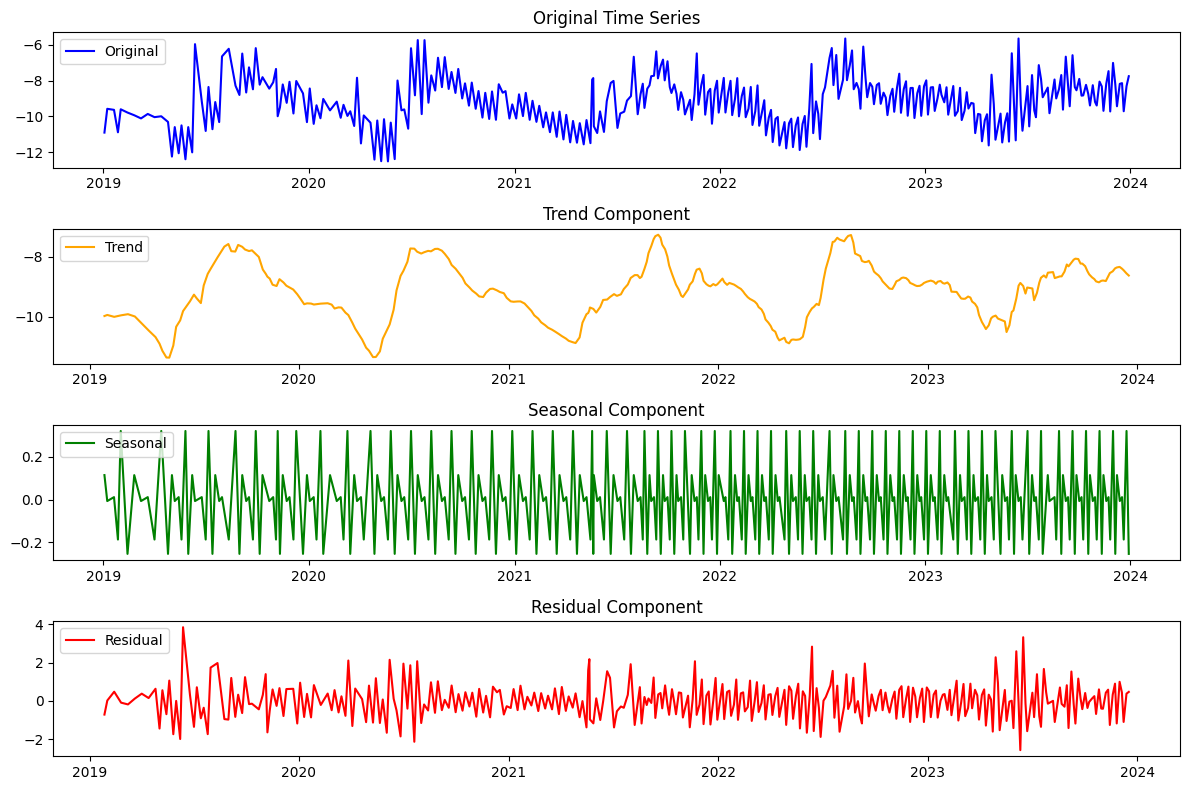

In [ ]:
valid_backscatter = df['backscatter'].tolist()
valid_dates = df['date'].tolist()

# Create a pandas series for time series decomposition
ts_data = pd.Series(valid_backscatter, index=valid_dates)

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=6)

# Plot decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(ts_data, label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


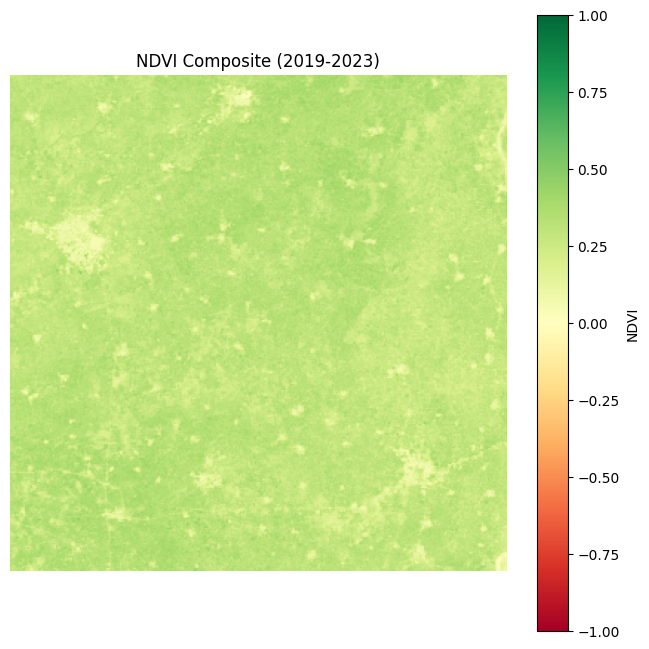

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

# Initialize the Earth Engine module
ee.Initialize()

# Define the region of interest as a rectangle
roi = ee.Geometry.Rectangle([72.5, 23.5, 72.8, 23.8])

# Define the date range for the analysis
start_date = '2019-01-01'
end_date = '2023-12-31'

# Filter Sentinel-2 image collection and calculate NDVI
sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate(start_date, end_date) \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Filter for less than 20% cloud coverage

# Define an NDVI calculation function
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi

# Apply NDVI calculation to each image in the collection
ndvi_collection = sentinel2.map(calculate_ndvi)

# Calculate the median NDVI image over the entire time period
ndvi_composite = ndvi_collection.median()

# Use geemap to get the image as a NumPy array with a larger scale to reduce data size
# Increase the scale to 100 meters
ndvi_array = geemap.ee_to_numpy(ndvi_composite.clip(roi), bands=['NDVI'], region=roi, scale=100)  # Scale set to 100

# Plot as before if the array is successfully retrieved
if ndvi_array is not None:
    plt.figure(figsize=(8, 8))
    plt.imshow(ndvi_array, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label="NDVI")
    plt.title("NDVI Composite (2019-2023)")
    plt.axis('off')
    plt.show()
else:
    print("The NDVI array is empty. Check the region and data availability.")



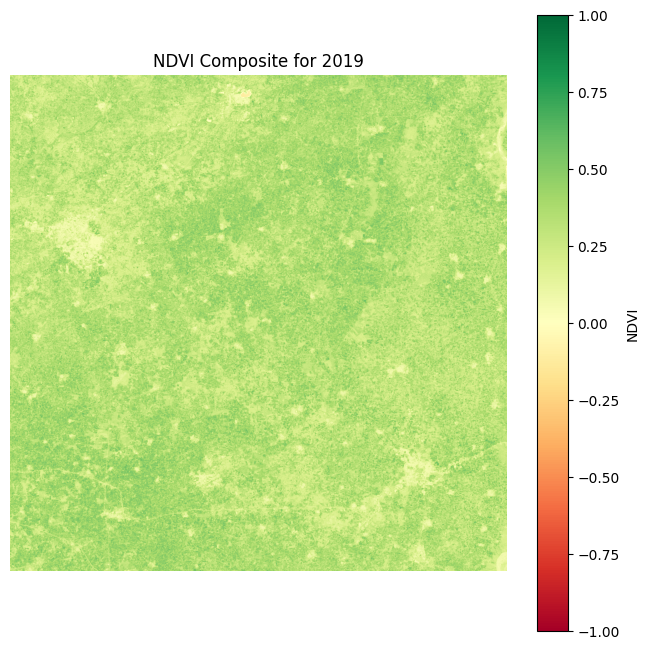

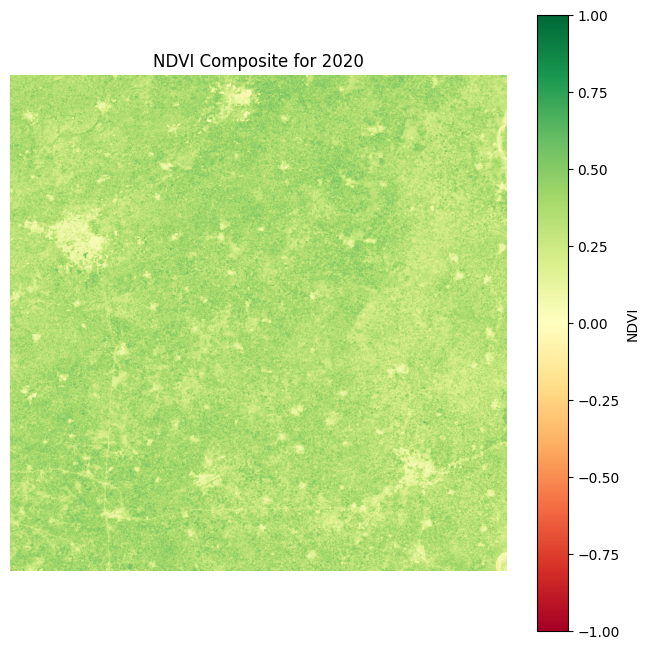

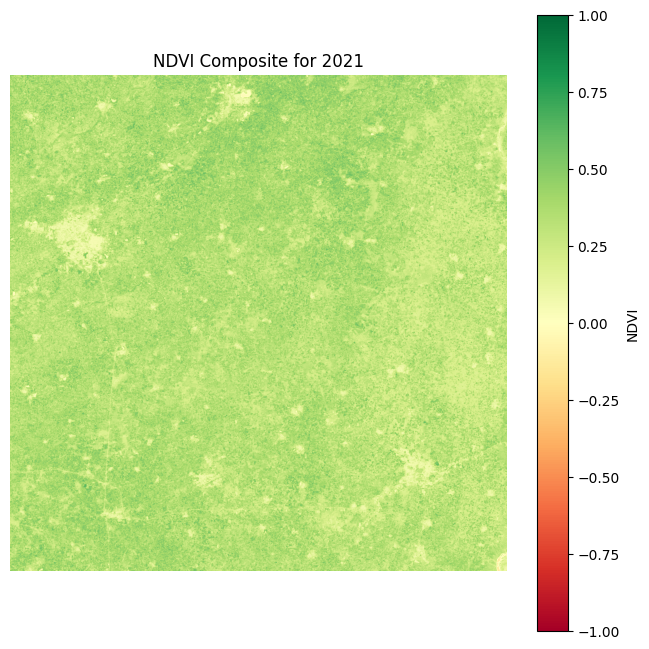

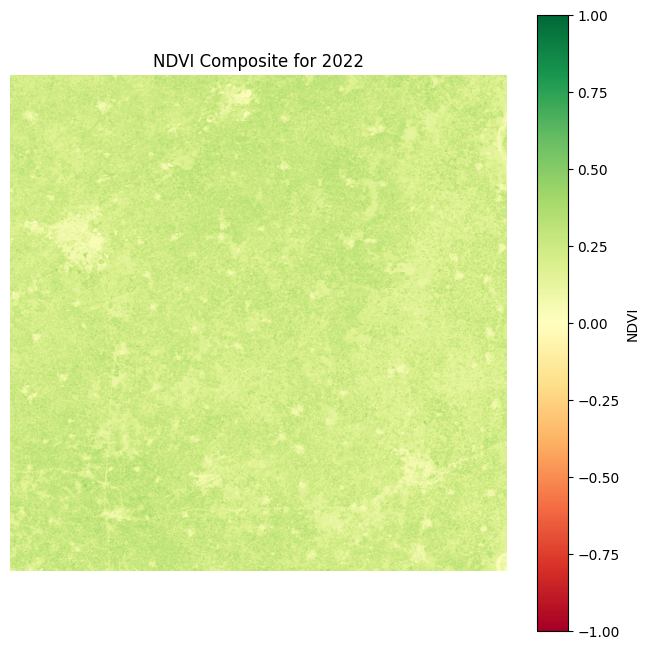

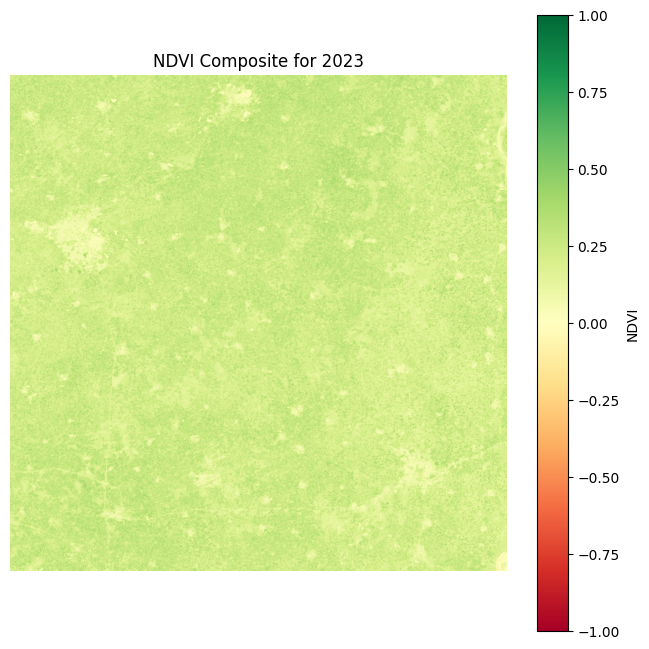

In [ ]:

# Function to calculate and display NDVI for a specific year
def plot_yearly_ndvi(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Filter Sentinel-2 image collection and calculate NDVI
    sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate(start_date, end_date) \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

    # Define an NDVI calculation function
    def calculate_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return ndvi

    # Apply NDVI calculation to each image in the collection
    ndvi_collection = ee.ImageCollection("COPERNICUS/S2") \
        .filterDate(start_date, end_date) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).map(calculate_ndvi)

    # Calculate the median NDVI image for the year
    ndvi_composite = ndvi_collection.median()

    # Convert to NumPy array with a higher scale
    ndvi_array = geemap.ee_to_numpy(ndvi_composite.clip(roi), bands=['NDVI'], region=roi, scale=30)

    # Plot the result
    if ndvi_array is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(ndvi_array, cmap='RdYlGn', vmin=-1, vmax=1)
        plt.colorbar(label="NDVI")
        plt.title(f"NDVI Composite for {year}")
        plt.axis('off')
        plt.show()
    else:
        print(f"No data available for {year}")

# Example: Plot for each year separately to reduce load
for year in range(2019, 2024):
    plot_yearly_ndvi(year)


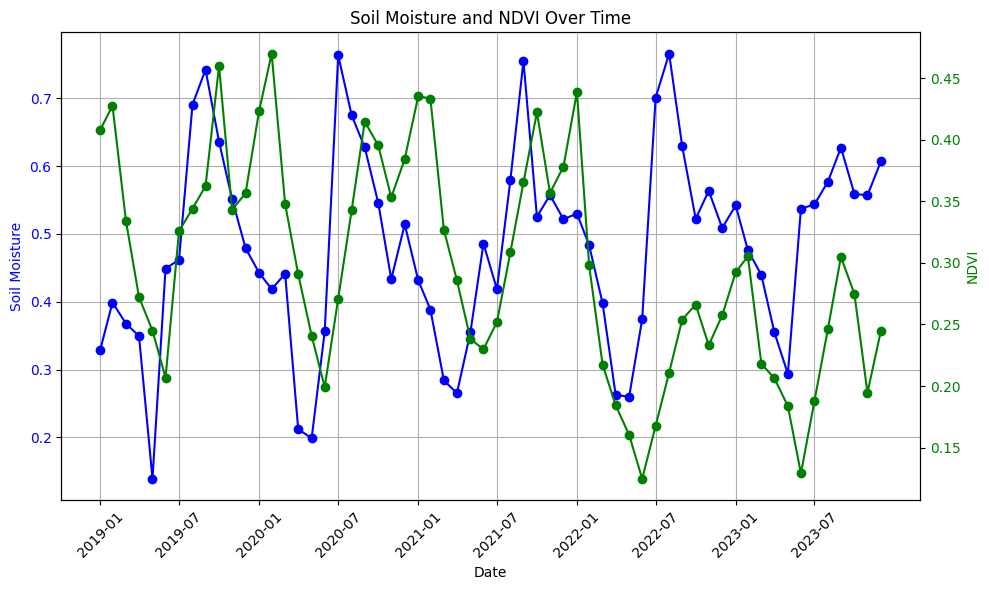

In [ ]:
# Assuming valid_dates and valid_backscatter are already available
# Filter to include only the specified date range
date_range_start = pd.Timestamp('2019-01-01')
date_range_end = pd.Timestamp('2023-12-31')

# Convert valid_dates to a DatetimeIndex if it's not already
valid_dates = pd.to_datetime(valid_dates)
valid_backscatter = np.array(valid_backscatter)

# Filter the valid_dates and valid_backscatter for the specified range
mask = (valid_dates >= date_range_start) & (valid_dates <= date_range_end)
valid_dates = valid_dates[mask]
valid_backscatter = valid_backscatter[mask]

# Create a DataFrame for soil moisture
soil_growth_df = pd.DataFrame({
    'Date': valid_dates,
    'Soil Moisture': valid_backscatter,  # Using backscatter as soil moisture
})

# Calculate Soil Moisture Index (SMI)
soil_growth_df['SMI'] = (soil_growth_df['Soil Moisture'] - soil_growth_df['Soil Moisture'].min()) / \
                         (soil_growth_df['Soil Moisture'].max() - soil_growth_df['Soil Moisture'].min())

# Resample data to monthly averages
soil_growth_monthly = soil_growth_df.set_index('Date').resample('M').mean().reset_index()

# ================= Fetch NDVI Data from Sentinel-2 ===================

# Define start_date and end_date here before they are used
start_date = '2019-01-01'  # Defining start_date
end_date = '2023-12-31'    # Defining end_date

# Load Sentinel-2 image collection and filter by date and ROI
sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate(start_date, end_date) \
    .filterBounds(roi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Filter for less than 20% cloud coverage

# Define an NDVI function
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Apply NDVI calculation to each image
ndvi_collection = sentinel2.map(calculate_ndvi)

# Function to compute mean NDVI and date
def get_mean_ndvi(image):
    mean_ndvi = image.select('NDVI').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=30,  # Using a coarser scale to avoid maxPixels issues
        bestEffort=True,
        maxPixels=1e8
    )
    return image.set({
        'mean_ndvi': mean_ndvi.get('NDVI'),
        'date': image.date().format()
    })



# Map the function to the collection
ndvi_time_series = ndvi_collection.map(get_mean_ndvi)

# Extract dates and NDVI values from the time series
dates = ndvi_time_series.aggregate_array('date').getInfo()
ndvi_data = ndvi_time_series.aggregate_array('mean_ndvi').getInfo()

# Convert date strings to datetime objects for plotting
# Convert date strings to datetime objects for plotting, accounting for the time component
dates = [datetime.strptime(date, '%Y-%m-%dT%H:%M:%S') for date in dates]


# Convert the NDVI date and data lists into a DataFrame
ndvi_df = pd.DataFrame({
    'Date': dates,
    'NDVI': ndvi_data
})

# Convert 'Date' to datetime if it's not already, then set as index
ndvi_df['Date'] = pd.to_datetime(ndvi_df['Date'])
ndvi_df.set_index('Date', inplace=True)

# Resample NDVI data to monthly frequency and interpolate missing values
ndvi_monthly = ndvi_df.resample('M').mean().interpolate()

# Reset the index to get 'Date' back as a column for plotting
ndvi_monthly = ndvi_monthly.reset_index()

# ================= Plotting the Graphs ==================

# 3. Dual-axis graph of Soil Moisture and Crop Growth (NDVI)
plt.figure(figsize=(10, 6))

# Plot Soil Moisture Index (SMI) on the first y-axis
ax1 = plt.gca()
ax1.plot(soil_growth_monthly['Date'], soil_growth_monthly['SMI'], marker='o', linestyle='-', color='blue', label='Soil Moisture')
ax1.set_ylabel('Soil Moisture', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Crop Growth (NDVI) on the second y-axis
ax2 = ax1.twinx()
ax2.plot(ndvi_monthly['Date'], ndvi_monthly['NDVI'], marker='o', linestyle='-', color='green', label='NDVI')
ax2.set_ylabel('NDVI', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and labels
plt.title('Soil Moisture and NDVI Over Time')
ax1.set_xlabel('Date')

# Set x-ticks and their rotation
ax1.set_xticks(soil_growth_monthly['Date'][::6])  # Show every 6 months
ax1.set_xticklabels(soil_growth_monthly['Date'].dt.strftime('%Y-%m')[::6], rotation=45)

ax1.grid()

# Show the plot
plt.tight_layout()
plt.show()
